In [1]:
import pandas as pd
import numpy as np
import os, time, stat, io, glob, pickle
from scipy.stats import gamma, norm
from sklearn.linear_model import LinearRegression
from IPython.core.display import display, HTML

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('fivethirtyeight')
import plotly.io as pio

%load_ext autoreload
%autoreload 2
from covid_data_helper import *
from coronita_chart_helper import *
from coronita_model_helper import *
from coronita_web_helper import *
from coronita_bokeh_helper import *

from matplotlib.backends.backend_pdf import PdfPages


In [34]:
df_st_testing = get_covid19_tracking_data()
df_st_testing_fmt = df_st_testing.copy()
df_st_testing_fmt = df_st_testing_fmt.rename(columns={'death':'deaths','positive':'cases'}).unstack('code')

State Testing Data Last Observation:  20210307
Got COVID19 Tracking Data
Got CDC Death Data
Got HHS testing data
Got HHS hospital data.


In [2]:
## DATA INGESTION ##

df_st_testing = get_covid19_tracking_data()

df_census = get_census_pop()

df_counties = get_complete_county_data()

counties_geo = get_counties_geo()

df_jhu_counties = get_jhu_counties()

df_st_testing_fmt = df_st_testing.copy()
df_st_testing_fmt = df_st_testing_fmt.rename(columns={'death':'deaths','positive':'cases'}).unstack('code')

df_interventions = get_state_policy_events()

df_goog_mob_us = get_goog_mvmt_us()
df_goog_mob_state = get_goog_mvmt_state(df_goog_mob_us)
df_goog_mob_us = df_goog_mob_us[df_goog_mob_us.state.isnull()].set_index('dt')

df_hhs_hosp = get_hhs_hosp()

State Testing Data Last Observation:  20210307
Got COVID19 Tracking Data
Got CDC Death Data
Got HHS testing data
Got HHS hospital data.
Got Census Data
Got NYS DOH data
Got Census Data
Got NYT county level data.
Got NYC DOH data
Got Google Movement Data
Got Complete County Data
Got counties geo json
Got JHU county level data.
Got KFF Policy dates
Got Google Movement Data
Got HHS hospitalization data.


In [3]:
## MODEL PARAMETERS ##

covid_params = {}
covid_params['d_incub'] = 3.
covid_params['d_infect'] = 4.
covid_params['mort_rt'] = 0.01
covid_params['d_in_hosp'] = 11
covid_params['hosp_rt'] = 0.04
covid_params['d_to_hosp'] = 7.0
covid_params['d_in_hosp_mild'] = 11.0
covid_params['icu_rt'] = 13./41.
covid_params['d_in_icu'] = 13.0
covid_params['vent_rt'] = 0.4
covid_params['d_til_death'] =  30.0
covid_params['policy_trigger'] = True
covid_params['policy_trigger_once'] = True

In [4]:
list_of_files = glob.glob('./output/df_fore_allstates_*.pkl') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)
df_fore_allstates = pd.read_pickle(latest_file)


./output/df_fore_allstates_20210224.pkl


In [5]:
list_of_files = glob.glob('./output/df_wavg_rt_conf_allregs_*.pkl') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)
df_wavg_rt_conf_allregs = pd.read_pickle(latest_file)


./output/df_wavg_rt_conf_allregs_20210224.pkl


In [6]:
list_of_files = glob.glob('./output/allstate_model_dicts_*.pkl') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)
with open(latest_file, 'rb') as handle:
    allstate_model_dicts = pickle.load(handle)
    

./output/allstate_model_dicts_20210224.pkl


In [7]:
allstate_model_dicts['KS']['df_agg'].head()

metric,exposed,infectious,recovered,hospitalized,deaths,hosp_admits,icu,vent,susceptible,exposed_daily,deaths_daily,hospitalized_fitted,deaths_fitted
dt,,,,,,,,,,,,,
2020-03-02,142.829164,100.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.913071e+06,42.829164,0.000000e+00,0.000000,0.000000e+00
2020-03-03,166.162514,118.310110,0.098618,0.056383,0.000000e+00,0.056383,0.017878,0.007151,2.913029e+06,41.798460,0.000000e+00,0.056383,0.000000e+00
2020-03-04,178.689640,150.853191,2.442670,0.249441,5.164151e-27,0.194111,0.079091,0.031636,2.912982e+06,47.607318,5.164151e-27,0.249441,5.164151e-27
2020-03-05,194.466369,182.119147,12.694655,0.577891,8.196482e-22,0.333045,0.183234,0.073293,2.912924e+06,57.623120,8.196431e-22,0.577891,8.196482e-22
2020-03-06,215.364540,203.452795,35.410245,1.018580,3.002588e-18,0.453127,0.322964,0.129186,2.912859e+06,65.388097,3.001769e-18,1.018580,3.002588e-18


In [8]:
allstate_model_dicts['KS']['df_hist'].head()

,deaths_tot,deaths_daily,hosp_concur,hosp_admits,cases_tot,cases_daily,pos_neg_tests_tot,pos_neg_tests_daily,hosp_beds_tot,hosp_beds_avail
dt,,,,,,,,,,
2020-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
from coronita_model_helper import fore_rmse

dftest = pd.DataFrame()
dftest['NY'] = fore_rmse(allstate_model_dicts['NY']['df_hist']['deaths_tot'], 
          allstate_model_dicts['NY']['df_agg']['deaths'])
dftest['KS'] = fore_rmse(allstate_model_dicts['KS']['df_hist']['deaths_tot'], 
          allstate_model_dicts['KS']['df_agg']['deaths'])
dftest

,NY,KS
rmse,61.257202,686.359609
avg_error,2067.683443,2472.718447
rel_error,1.065754,3.106785


deaths shifted by:  -33


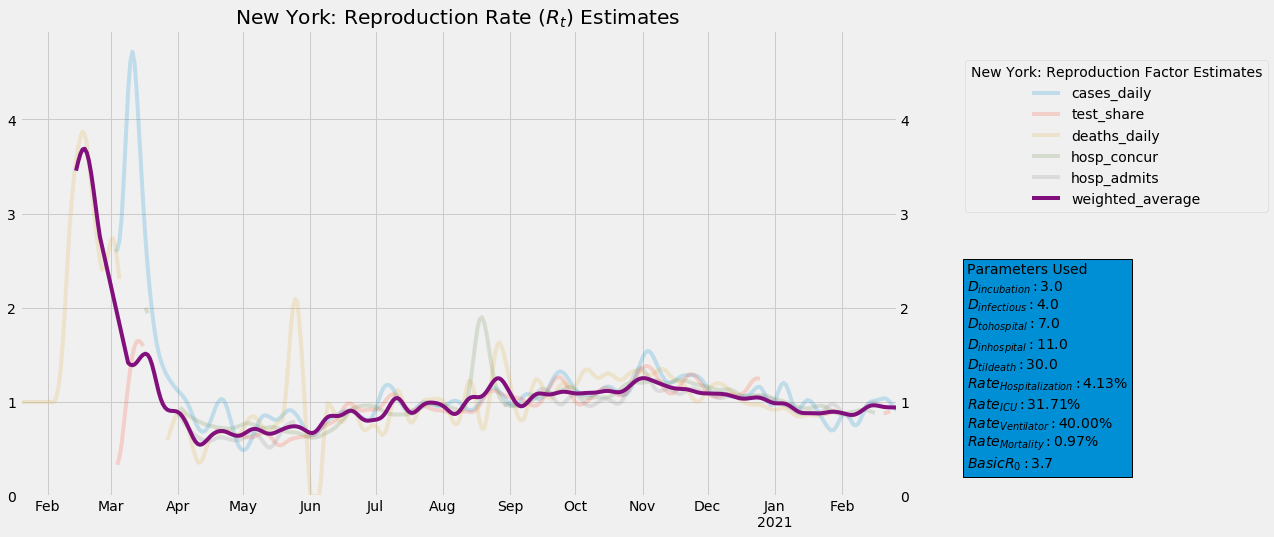

This guess:  2020-02-07 00:00:00
This rmse:  1259.1634186893045
Change in rmse:  -1
Average Error:  18968.52034975492
This guess:  2020-01-31 00:00:00
This rmse:  966.7560631561718
Change in rmse:  -292.4073555331328
Average Error:  14466.875992221749
This guess:  2020-01-24 00:00:00
This rmse:  294.6081311274703
Change in rmse:  -672.1479320287015
Average Error:  -4445.533980742704
This guess:  2020-01-25 00:00:00
This rmse:  87.67541098123962
Change in rmse:  -206.93272014623068
Average Error:  156.06136556500476
This guess:  2020-01-24 00:00:00
This rmse:  294.6081311274703
Change in rmse:  206.93272014623068
Average Error:  -4445.533980742704
Best starting date:  2020-01-25 00:00:00


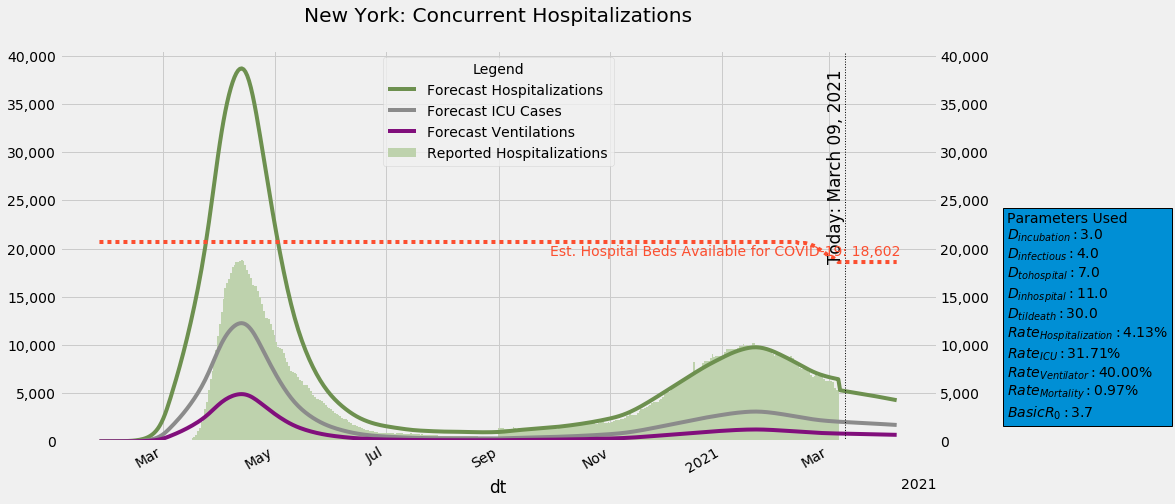

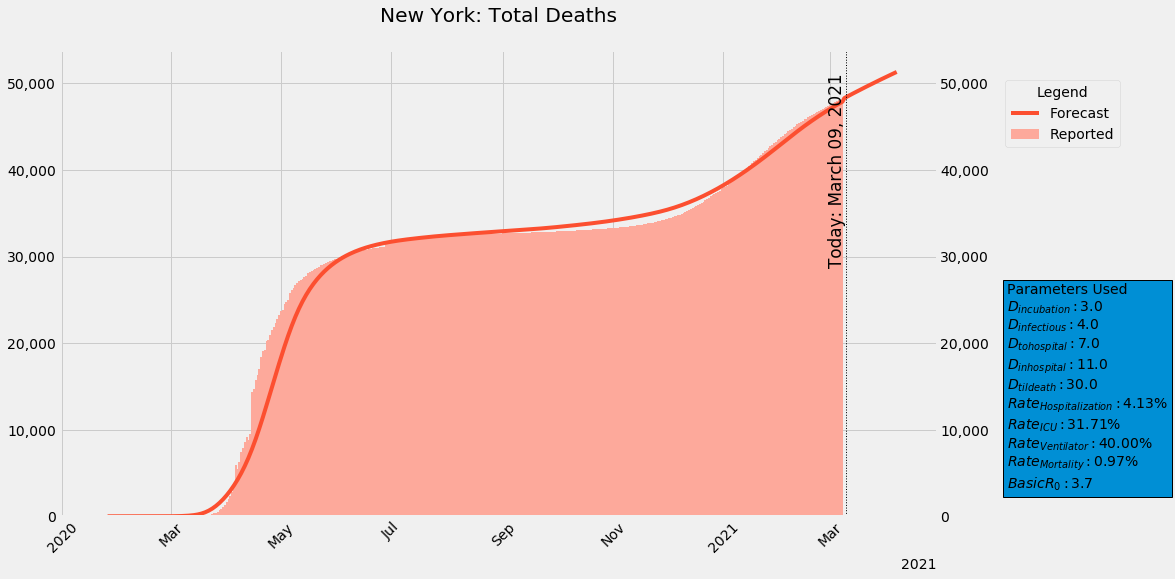

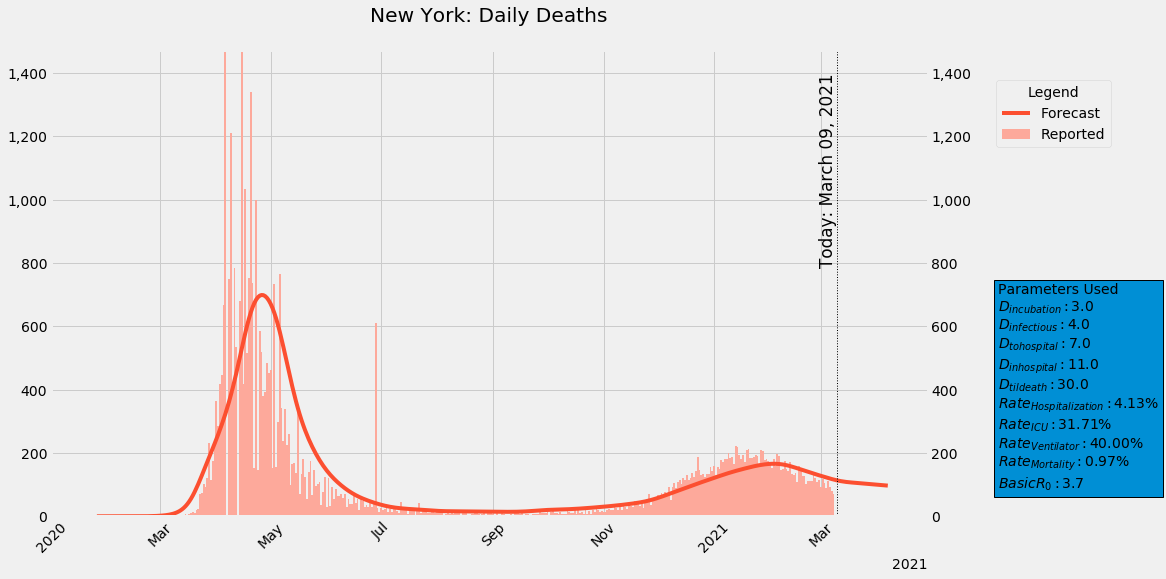

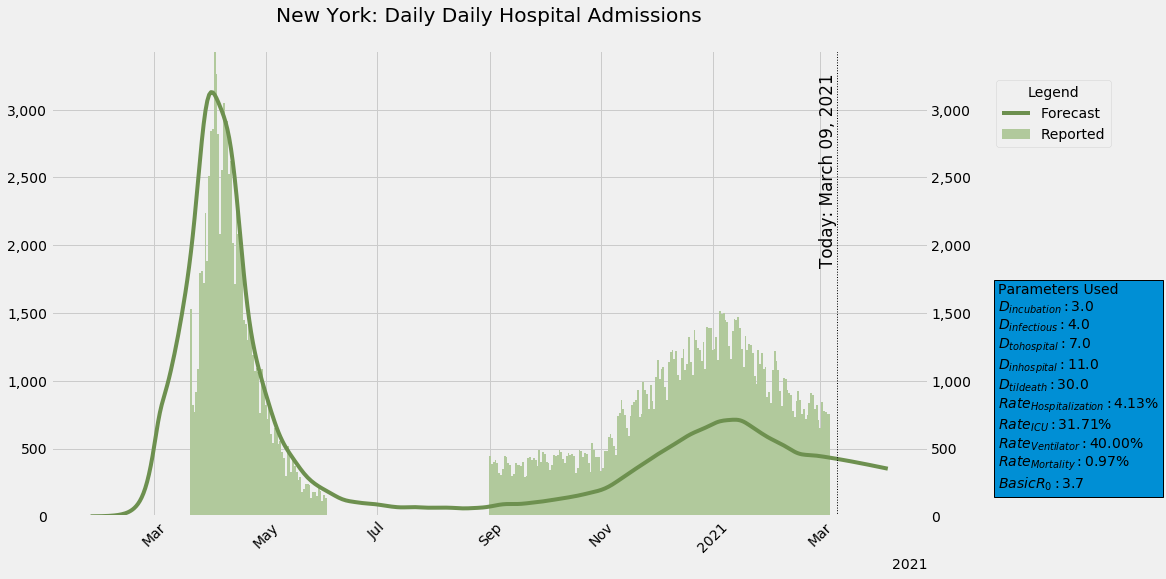

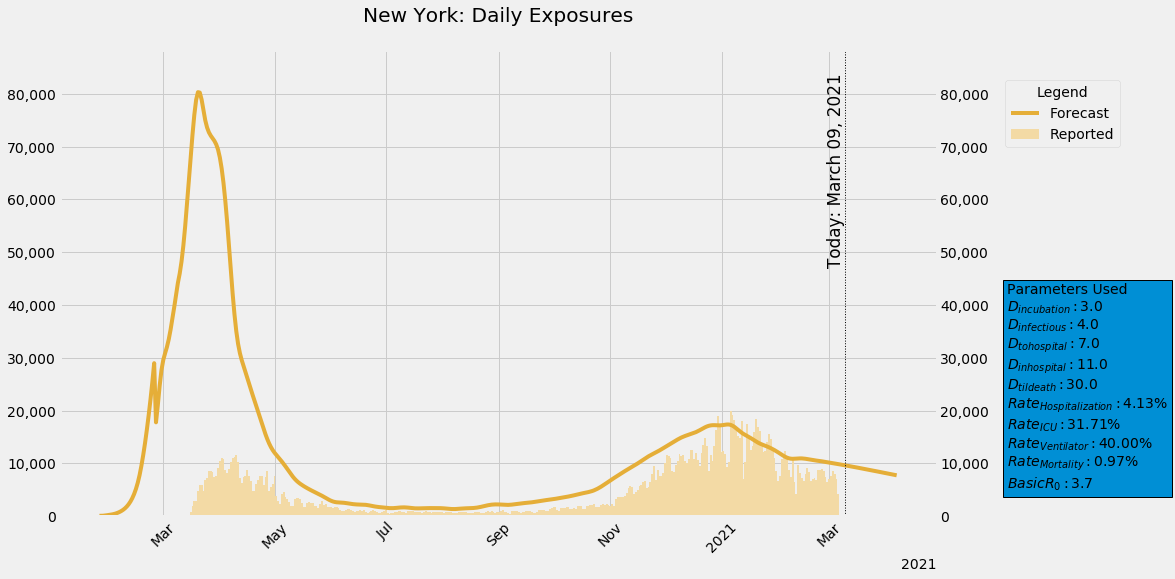

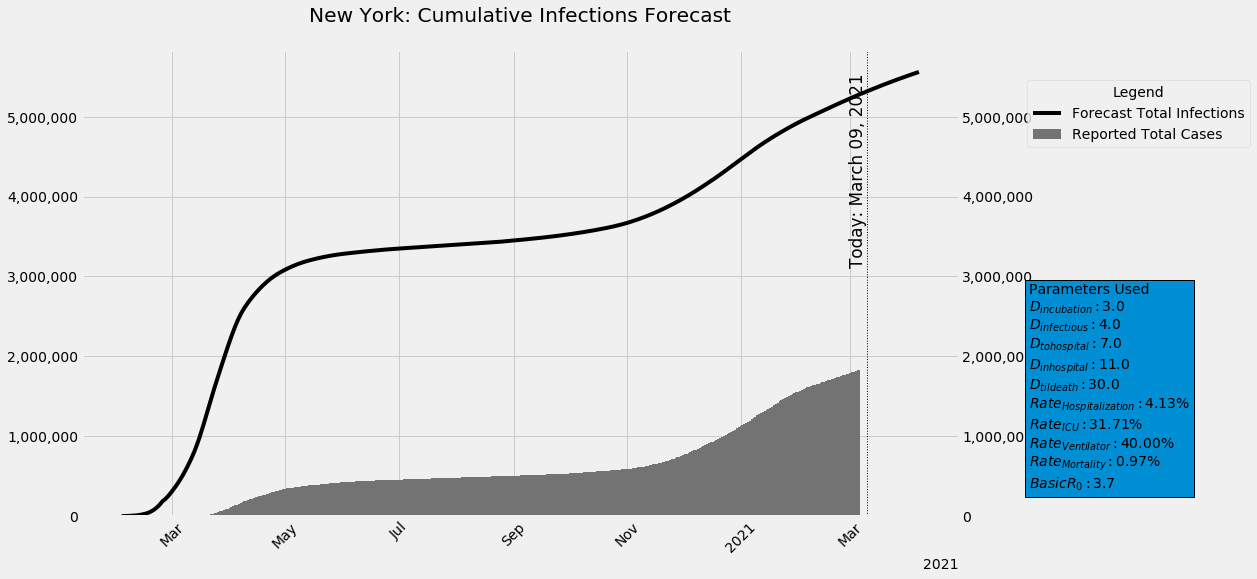

In [35]:
state = 'NY'
model_dict = make_model_dict_state(state, abbrev_us_state, df_census, df_st_testing_fmt, df_hhs_hosp,
                                       covid_params, 30,
                                       df_mvmt=df_goog_mob_state
                                     , df_interventions=df_interventions
                                      )
ch_rts(model_dict); plt.show()
model_dict = model_find_start('2020-02-07', model_dict)
ch_hosp_concur(model_dict); plt.show()
ch_deaths_tot(model_dict); plt.show()
ch_daily_deaths(model_dict); plt.show()
ch_hosp_admits(model_dict); plt.show()
ch_daily_exposures(model_dict); plt.show()
ch_cumul_infections(model_dict); plt.show()

deaths shifted by:  -33


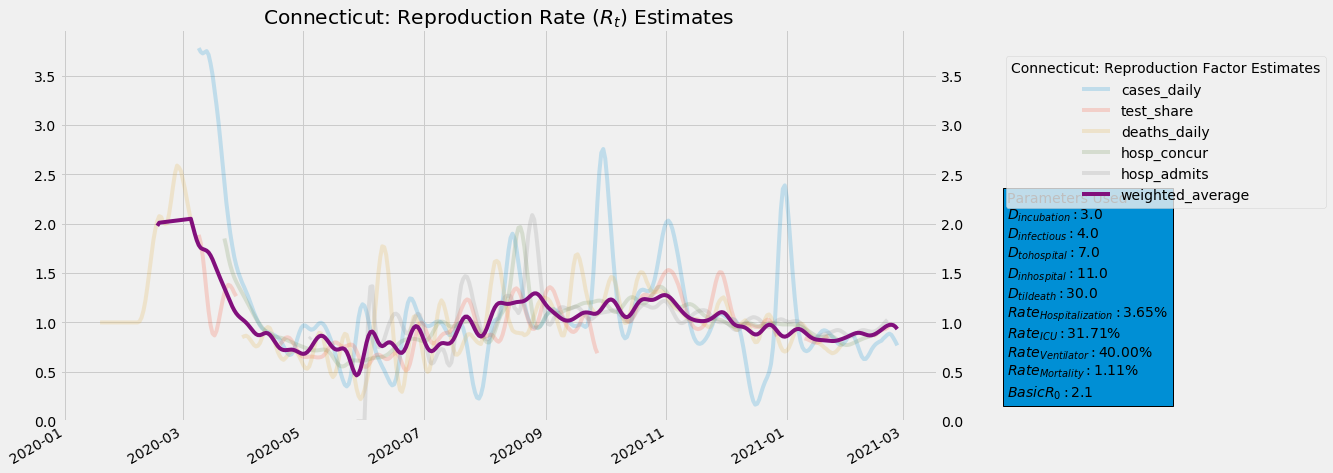

This guess:  2020-02-07 00:00:00
This rmse:  728.2665338664605
Change in rmse:  -1
Average Error:  1599.1423160325446
This guess:  2020-01-31 00:00:00
This rmse:  142.47964355143165
Change in rmse:  -585.7868903150288
Average Error:  -43.69860079134009
This guess:  2020-02-01 00:00:00
This rmse:  155.8031133852272
Change in rmse:  13.323469833795542
Average Error:  274.8401119697399
Best starting date:  2020-01-31 00:00:00


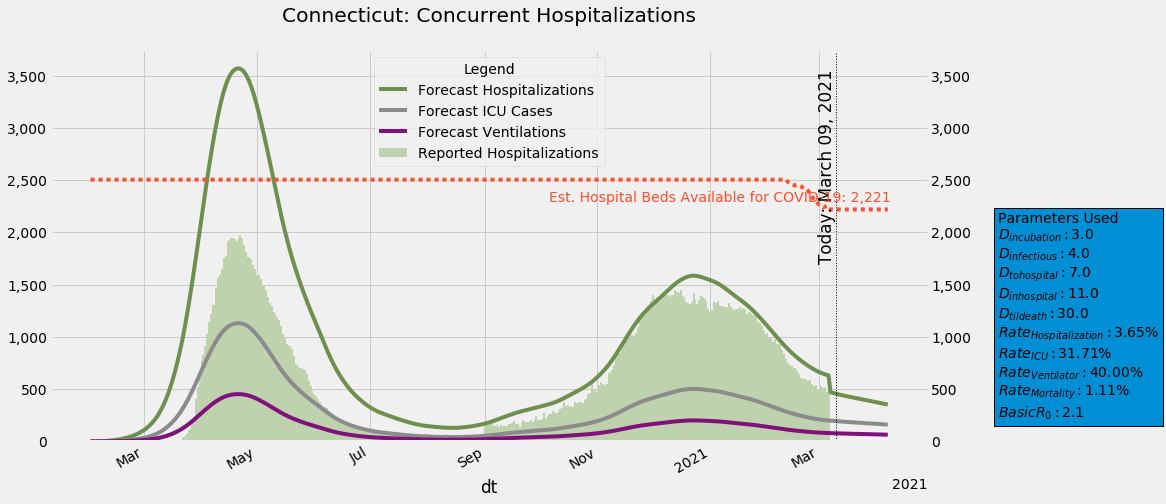

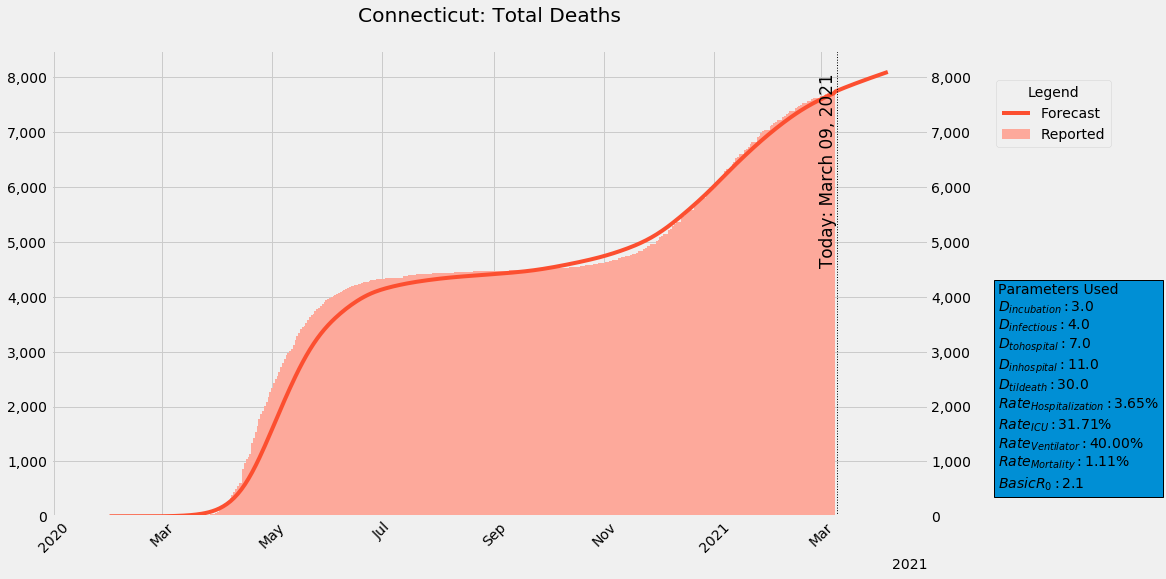

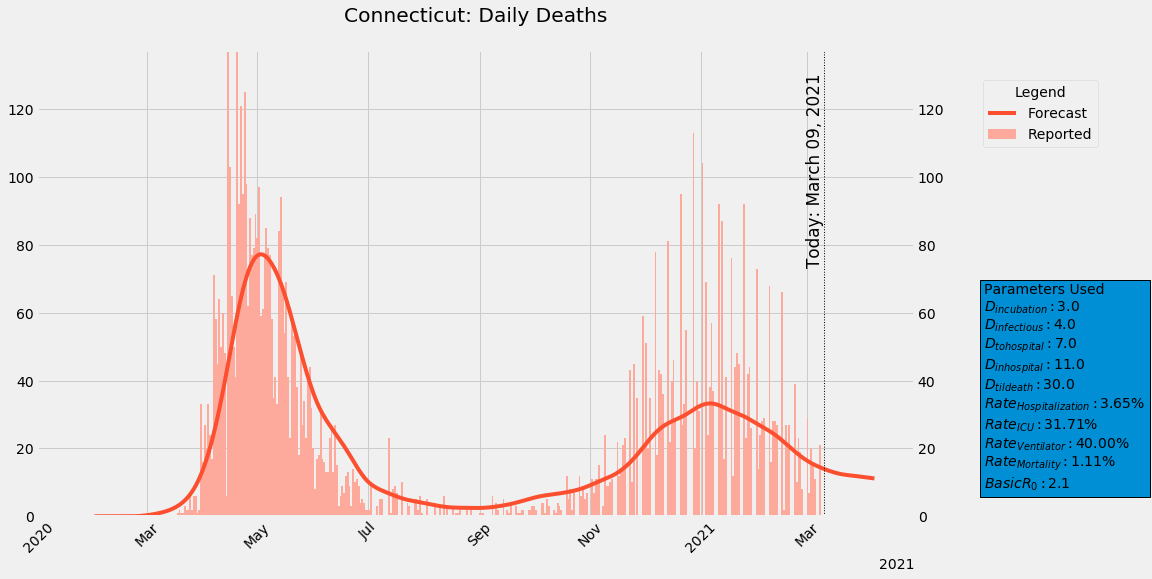

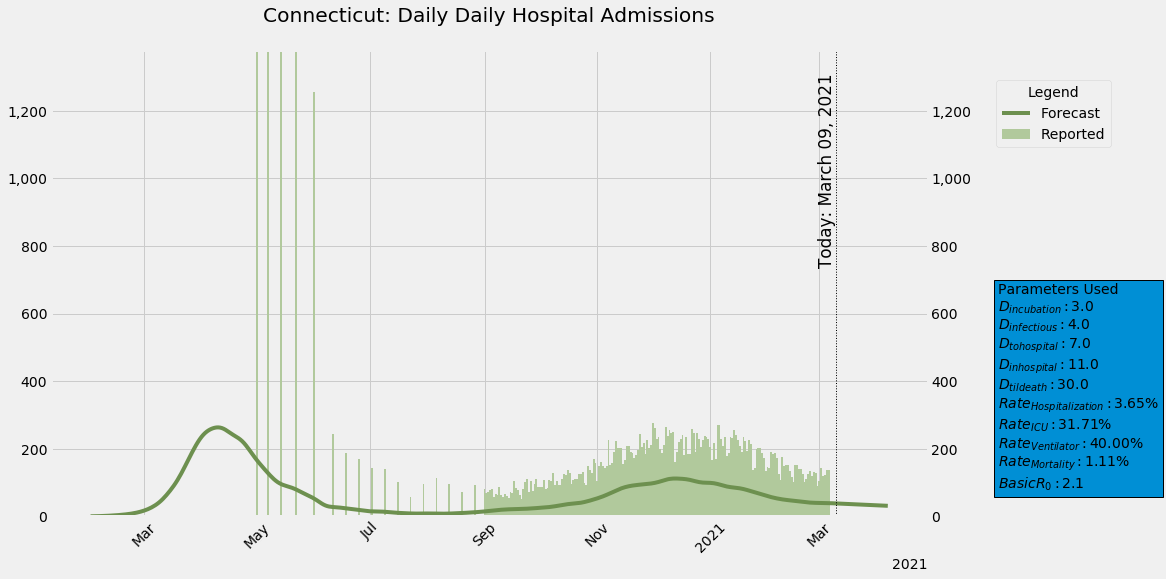

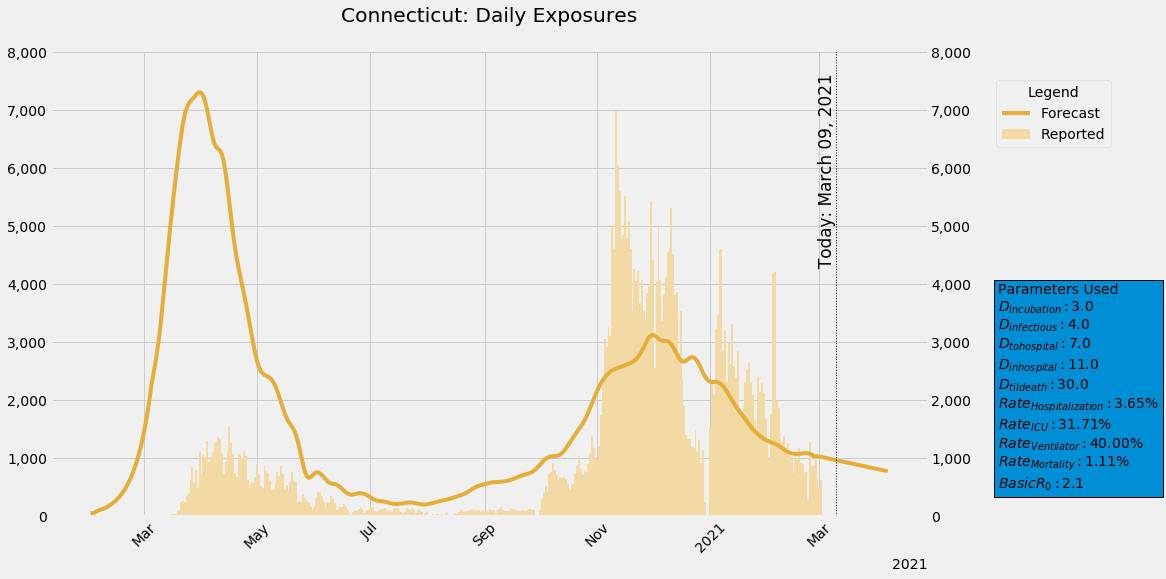

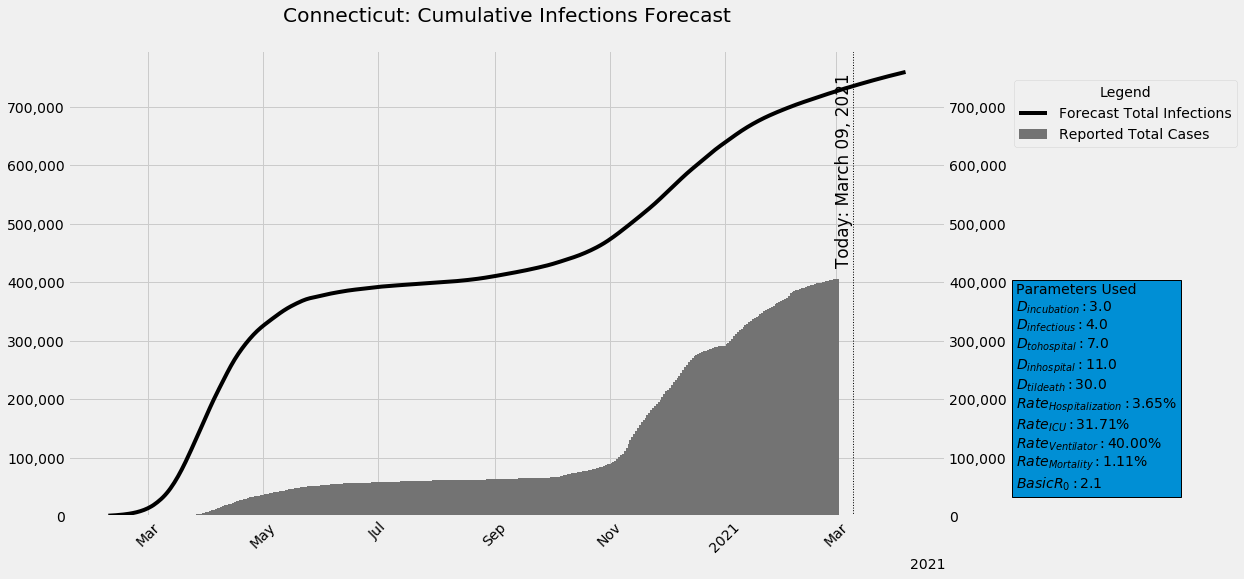

In [36]:
state = 'CT'
model_dict = make_model_dict_state(state, abbrev_us_state, df_census, df_st_testing_fmt, df_hhs_hosp,
                                       covid_params, 30,
                                       df_mvmt=df_goog_mob_state
                                     , df_interventions=df_interventions
                                      )
ch_rts(model_dict); plt.show()
model_dict = model_find_start('2020-02-07', model_dict)
ch_hosp_concur(model_dict); plt.show()
ch_deaths_tot(model_dict); plt.show()
ch_daily_deaths(model_dict); plt.show()
ch_hosp_admits(model_dict); plt.show()
ch_daily_exposures(model_dict); plt.show()
ch_cumul_infections(model_dict); plt.show()

deaths shifted by:  -33


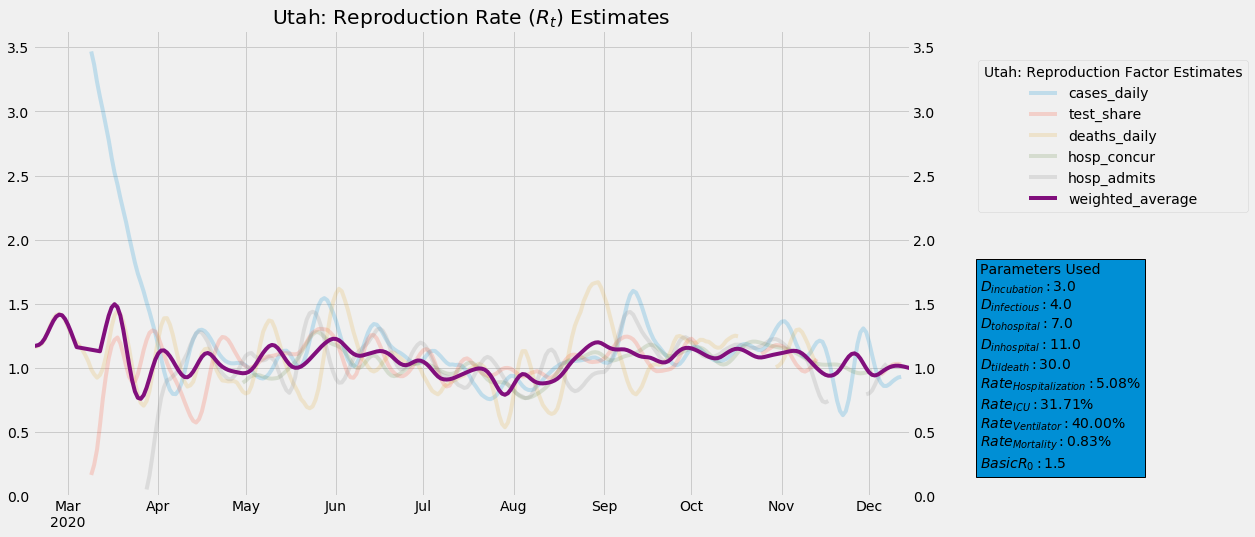

This guess:  2020-03-03 00:00:00
This rmse:  581.1533088254743
Change in rmse:  -1
Average Error:  -152.68498784095084
This guess:  2020-03-04 00:00:00
This rmse:  545.258424305957
Change in rmse:  -35.89488451951729
Average Error:  -105.62958537827289
This guess:  2020-03-05 00:00:00
This rmse:  512.8838313830486
Change in rmse:  -32.37459292290839
Average Error:  -61.43987546847992
This guess:  2020-03-06 00:00:00
This rmse:  483.4311776920877
Change in rmse:  -29.452653690960858
Average Error:  -19.93810170685153
This guess:  2020-03-07 00:00:00
This rmse:  456.7527950442989
Change in rmse:  -26.678382647788794
Average Error:  19.02922062529844
This guess:  2020-03-06 00:00:00
This rmse:  483.4311776920877
Change in rmse:  26.678382647788794
Average Error:  -19.93810170685153
Best starting date:  2020-03-07 00:00:00


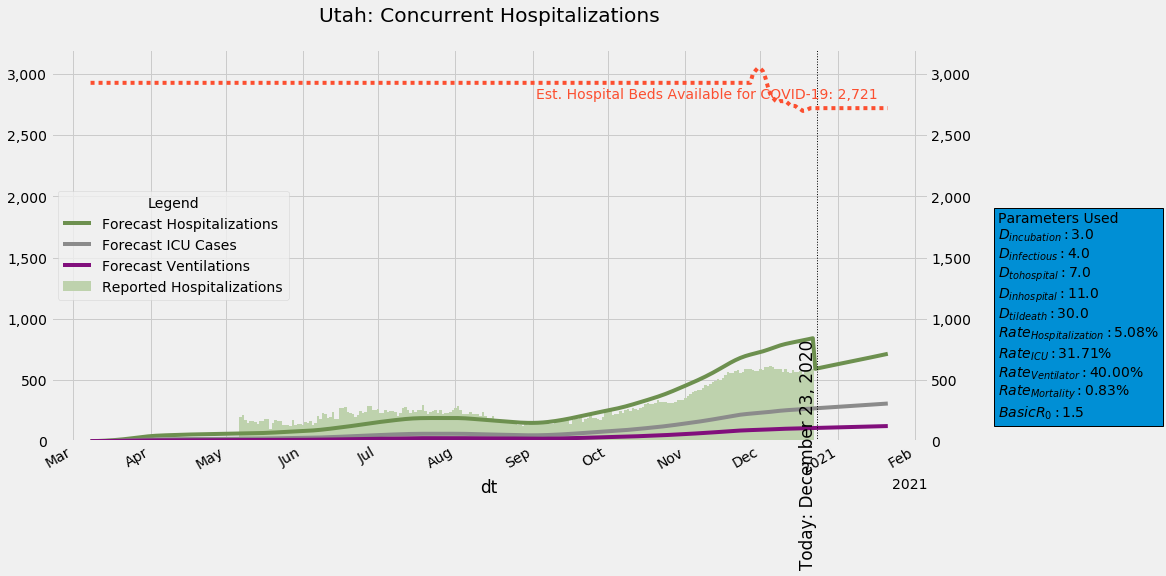

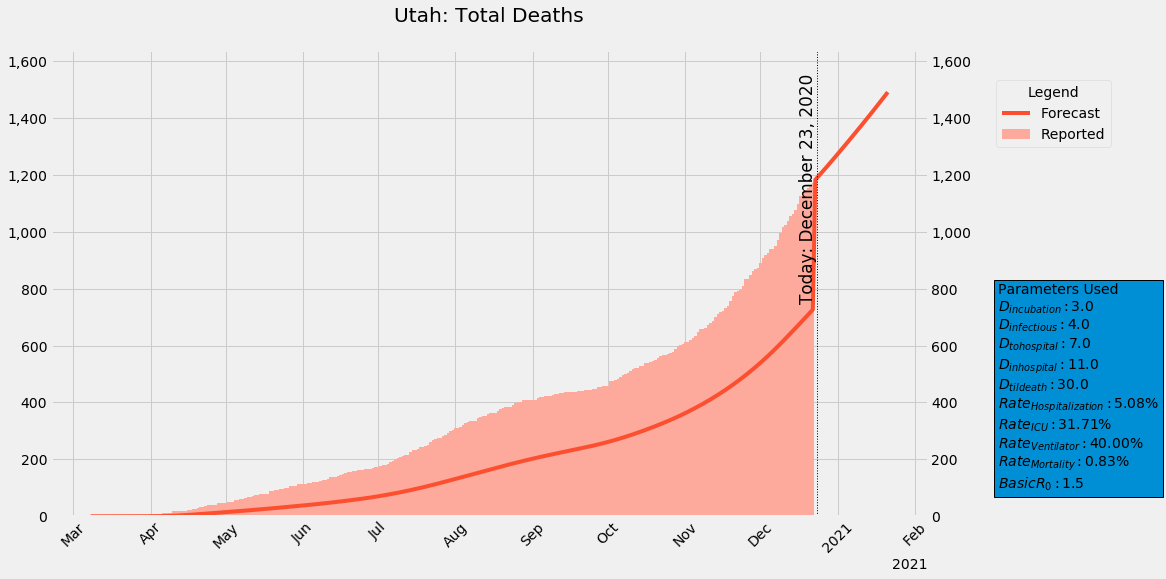

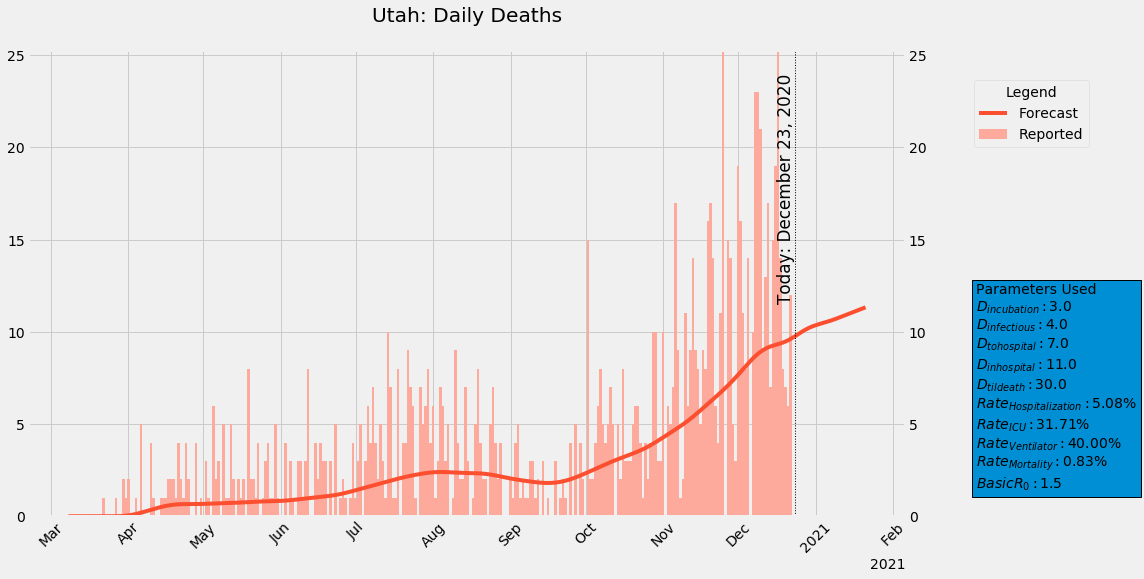

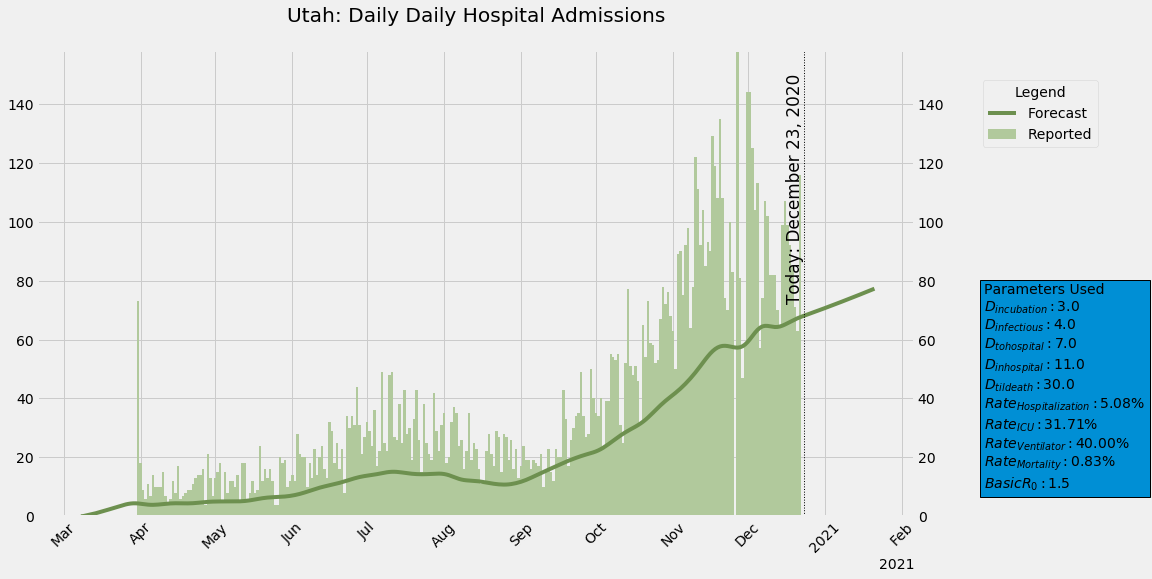

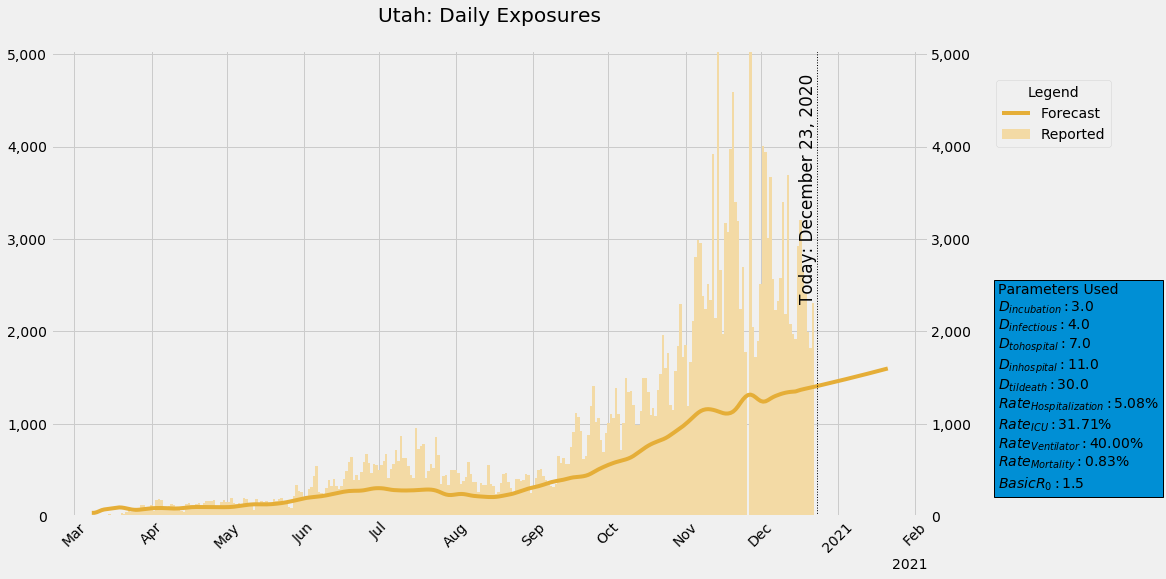

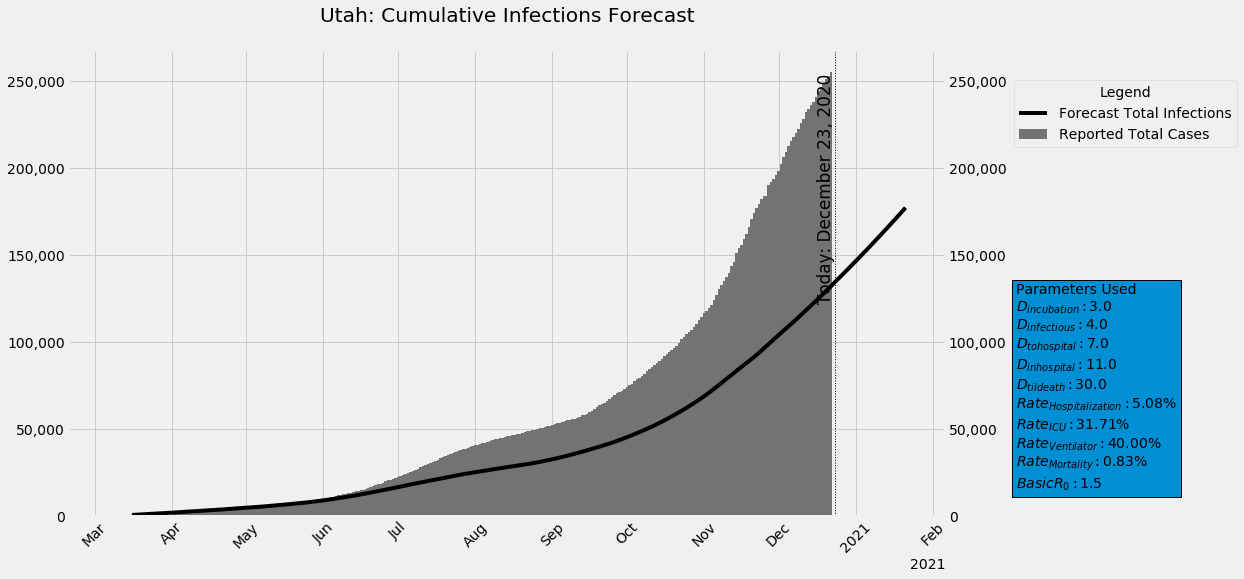

In [33]:
state = 'UT'
model_dict = make_model_dict_state(state, abbrev_us_state, df_census, df_st_testing_fmt, df_hhs_hosp,
                                       covid_params, 30,
                                       df_mvmt=df_goog_mob_state
                                     , df_interventions=df_interventions
                                      )
ch_rts(model_dict); plt.show()
model_dict = model_find_start('2020-03-03', model_dict)
ch_hosp_concur(model_dict); plt.show()
ch_deaths_tot(model_dict); plt.show()
ch_daily_deaths(model_dict); plt.show()
ch_hosp_admits(model_dict); plt.show()
ch_daily_exposures(model_dict); plt.show()
ch_cumul_infections(model_dict); plt.show()

In [400]:
covid_params_ut = covid_params.copy()

# covid_params_ut['d_to_hosp'] = 12.0 
covid_params_ut['d_in_hosp'] = 4.0

covid_params_ut['mort_rt'] = 0.003
covid_params_ut['hosp_rt'] = 0.015
covid_params_ut

state = 'UT'
model_dict = make_model_dict_state(state, abbrev_us_state, df_census, df_st_testing_fmt, df_hhs_hosp,
                                       covid_params_ut, 30,
                                       df_mvmt=df_goog_mob_state
                                     , df_interventions=df_interventions
                                      )
model_dict = model_find_start('2020-02-07', model_dict)
ch_hosp_concur(model_dict); plt.show()
ch_deaths_tot(model_dict); plt.show()
ch_daily_deaths(model_dict); plt.show()
ch_hosp_admits(model_dict); plt.show()
ch_rts(model_dict); plt.show()
ch_daily_exposures(model_dict); plt.show()
ch_cumul_infections(model_dict); plt.show()

{'d_incub': 3.0,
 'd_infect': 4.0,
 'mort_rt': 0.003,
 'd_in_hosp': 4.0,
 'hosp_rt': 0.015,
 'd_to_hosp': 7.0,
 'd_in_hosp_mild': 11.0,
 'icu_rt': 0.3170731707317073,
 'd_in_icu': 13.0,
 'vent_rt': 0.4,
 'd_til_death': 17.0,
 'policy_trigger': True,
 'policy_trigger_once': True}

# Time varying parameter estimate

In [104]:
print(df_st_testing.columns)
df_st_testing.head()

Index(['date', 'positive', 'probableCases', 'negative', 'pending',
       'totalTestResultsSource', 'totalTestResults', 'hospitalizedCurrently',
       'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
       'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered',
       'dataQualityGrade', 'lastUpdateEt', 'dateModified', 'checkTimeEt',
       'death', 'hospitalized', 'dateChecked', 'totalTestsViral',
       'positiveTestsViral', 'negativeTestsViral', 'positiveCasesViral',
       'deathConfirmed', 'deathProbable', 'totalTestEncountersViral',
       'totalTestsPeopleViral', 'totalTestsAntibody', 'positiveTestsAntibody',
       'negativeTestsAntibody', 'totalTestsPeopleAntibody',
       'positiveTestsPeopleAntibody', 'negativeTestsPeopleAntibody',
       'totalTestsPeopleAntigen', 'positiveTestsPeopleAntigen',
       'totalTestsAntigen', 'positiveTestsAntigen', 'fips', 'positiveIncrease',
       'negativeIncrease', 'total', 'totalTestResultsIncrease', 'posNeg',
     

date  positive  probableCases  negative  pending  \
code dt                                                                 
AK   2020-03-06  20200306       NaN            NaN       8.0      1.0   
     2020-03-07  20200307       NaN            NaN      12.0      2.0   
     2020-03-08  20200308       NaN            NaN      14.0      6.0   
     2020-03-09  20200309       NaN            NaN      23.0      9.0   
     2020-03-10  20200310       NaN            NaN      23.0      9.0   

                totalTestResultsSource  totalTestResults  \
code dt                                                    
AK   2020-03-06        totalTestsViral               8.0   
     2020-03-07        totalTestsViral              12.0   
     2020-03-08        totalTestsViral              14.0   
     2020-03-09        totalTestsViral              23.0   
     2020-03-10        totalTestsViral              23.0   

                 hospitalizedCurrently  hospitalizedCumulative  \
code dt                                                          
AK   2020-03-06                    NaN                     NaN   
     2020-03-07                    NaN                     NaN   
     2020-03-08                    NaN                     NaN   
     2020-03-09                    NaN                     1.0   
     2020-03-10                    NaN                     1.0   

                 inIcuCurrently  ...  posNeg  deathIncrease  \
code dt                          ...                          
AK   2020-03-06             NaN  ...       8              0   
     2020-03-07             NaN  ...      12              0   
     2020-03-08             NaN  ...      14              0   
     2020-03-09             NaN  ...      23              0   
     2020-03-10             NaN  ...      23              0   

                 hospitalizedIncrease  \
code dt                                 
AK   2020-03-06                     0   
     2020-03-07                     0   
     2020-03-08                     0   
     2020-03-09                     1   
     2020-03-10                     0   

                                                     hash commercialScore  \
code dt                                                                     
AK   2020-03-06  1cccb785fe70d960475d4b202a3d0fc678c81e41               0   
     2020-03-07  a2776acac3d2b1dea060a3c20f4b508d5c00fd3d               0   
     2020-03-08  ec0512b5cc8703196f5901589feb0640e43a851a               0   
     2020-03-09  d079fbd221af733f452c4c09a96059c1b7403d68               0   
     2020-03-10  3dc91f117f02b4ceb2740f1b7a0f50fe7f7a67e7               0   

                negativeRegularScore negativeScore positiveScore  score  grade  
code dt                                                                         
AK   2020-03-06                    0             0             0      0    NaN  
     2020-03-07                    0             0             0      0    NaN  
     2020-03-08                    0             0             0      0    NaN  
     2020-03-09                    0             0             0      0    NaN  
     2020-03-10                    0             0             0      0    NaN  

[5 rows x 54 columns]

(0, 20)

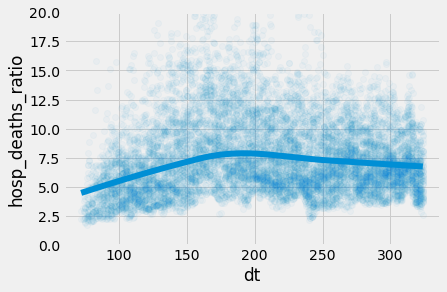

In [289]:
import seaborn as sns
deaths_shift = int(model_dict['covid_params']['d_incub'] + model_dict['covid_params']['d_til_death']) * -1
hosp_concur_shift = (int(model_dict['covid_params']['d_incub']
                                 + model_dict['covid_params']['d_to_hosp']
                                 + model_dict['covid_params']['d_in_hosp'] / 2)
                             * -1)

df_ratio = df_st_testing[['hospitalizedCurrently','death']].copy()
df_ratio = df_ratio.unstack('code')

df_ratio['death'] = df_ratio['death'].shift(deaths_shift)
df_ratio['death'] = df_ratio['death'].diff().rolling(7).sum()

df_ratio['hospitalizedCurrently'] = df_ratio['hospitalizedCurrently'].shift(hosp_concur_shift)
df_ratio['hospitalizedCurrently'] = df_ratio['hospitalizedCurrently'].rolling(7).mean()

df_chart = df_ratio['hospitalizedCurrently'].div(df_ratio.death).stack().replace(np.inf,np.nan)

df_chart = df_chart.reset_index().rename(columns={0:'hosp_deaths_ratio'}).dropna()
df_chart['dt'] = (df_chart.dt - pd.Timestamp('2020-01-01')).dt.days

low_lim = df_chart.groupby('dt')['hosp_deaths_ratio'].quantile(0.05)
up_lim = df_chart.groupby('dt')['hosp_deaths_ratio'].quantile(0.95)
df_chart = df_chart.set_index('dt')[['hosp_deaths_ratio']]
df_chart = df_chart[(df_chart.hosp_deaths_ratio.lt(up_lim)) & (df_chart.hosp_deaths_ratio.gt(low_lim))].reset_index()

# ax = df_chart.plot.scatter(x='dt',y=0, alpha=0.1, figsize=[14,6])
ax = sns.regplot(x='dt',y='hosp_deaths_ratio', 
                 data=df_chart, 
                 n_boot=500, lowess=True,
                 scatter_kws={'alpha':0.03})
ax.set_ylim([0,20])


,hosp_deaths_ratio
dt,
72,2.913894
72,2.244179
73,3.166071
73,2.228595
74,2.967857
...,...
324,9.469605
324,6.308950
324,4.046527


In [295]:
model_dict = allstate_model_dicts['MT']

deaths_shift = int(model_dict['covid_params']['d_incub'] + model_dict['covid_params']['d_til_death']) * -1
hosp_concur_shift = (int(model_dict['covid_params']['d_incub']
                                 + model_dict['covid_params']['d_to_hosp']
                                 + model_dict['covid_params']['d_in_hosp'] / 2)
                             * -1)

df_dhratio = model_dict['df_hist'][['deaths_daily','hosp_concur']].copy()

df_dhratio['deaths_daily'] = df_dhratio['deaths_daily'].rolling(7).sum().shift(deaths_shift)
df_dhratio['hosp_concur'] = df_dhratio['hosp_concur'].rolling(7).mean().shift(hosp_concur_shift)
df_dhratio = df_dhratio.dropna()

deaths_hosp_rat = np.linalg.lstsq(df_dhratio['deaths_daily'].values.reshape(-1, 1),
                                  df_dhratio['hosp_concur'], rcond=None)[0][0]

old_ratio = model_dict['covid_params']['hosp_rt'] / model_dict['covid_params']['mort_rt']
hosp_rt = ((deaths_hosp_rat / old_ratio - 1) / 2 + 1) * model_dict['covid_params']['hosp_rt']
mort_rt = model_dict['covid_params']['hosp_rt'] / deaths_hosp_rat
print(deaths_hosp_rat, hosp_rt, mort_rt)

5.794394020558405 0.0517838899960631 0.005940922745934354


In [176]:
deaths_hosp_rat = np.linalg.lstsq(
    model_dict['df_hist'][['deaths_daily','hosp_concur']].dropna()['deaths_daily'].values.reshape(-1, 1),
                                  model_dict['df_hist'][['deaths_daily','hosp_concur']].dropna()['hosp_concur'],
                                  rcond=None)[0][0] / 9.0


old_ratio = model_dict['covid_params']['hosp_rt'] / model_dict['covid_params']['mort_rt']
model_dict['covid_params']['hosp_rt'] = ((deaths_hosp_rat / old_ratio - 1) / 2 + 1) * model_dict['covid_params']['hosp_rt']
model_dict['covid_params']['mort_rt'] = model_dict['covid_params']['hosp_rt'] / deaths_hosp_rat

,deaths_daily,hosp_concur
dt,,
2020-07-25,0.0,315.0
2020-07-26,0.0,315.0
2020-07-27,9.0,212.0
2020-07-28,0.0,212.0
2020-07-29,14.0,393.0
...,...,...
2020-12-06,0.0,1143.0
2020-12-07,70.0,623.0
2020-12-08,0.0,623.0
